# Assignment 4 - Data Science in Finance and Insurance
Submission by: Dennis Goldenberg

In [2]:
#Import Statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

## Part [init] - Performing Underlying LOWESS Regression

### Read in Data, Scale Distances
To find the local neighborhoods of each of the generated points of the xgrid for LOWESS regression, I first have to create the grid of 50 values, uniformly spaced between $\min(x)$ and $\max(x)$ in the data. After creating this grid, I run a 1-dimensional KNearest-Neighbors alogrithm to find the $K = 7$ closest neighbors to each point as well as their distances from said point; I then scale those distances by the largest neighbor using the algorithm:
\begin{equation*}
d_{i,j}^{*} = \frac{d_{i, j}}{\max\{d_{i,1}, ..., d_{i,7}\}} \text{ } \forall i \in [50]
\end{equation*}

In [160]:
K = 7;
#read in data
rawData = pd.read_csv("data.csv")


#Create nearest neghbors algorithm, use p = 1 for l1-norm
nn = NearestNeighbors(n_neighbors = K, p = 1).fit(np.asarray(rawData['x']).reshape(-1, 1));

#Generate x vals to regress on, find nearest neighbors in dataset
xgrid = np.linspace(rawData['x'].min(), rawData['x'].max(), 50)
kn = nn.kneighbors(xgrid.reshape(-1, 1), K, return_distance= True)

#find max distances - using the 7th nearest neighbor, neighbors in ascending order of distance
distances = kn[0]
maxdistances = np.expand_dims(kn[0][:,6], axis = 1)

#Get scaled distances
scaled_dist = distances/maxdistances


### Derive Weights using tri-cube function
To get the weights for the LOWESS function, i use the tri-cube function with the following algorithm:
\begin{equation*}
 w_{i,j} = \begin{cases} (1 - |d_{i,j}|^3)^3 & |d_{i,j} \leq 1| \text{for points in $x_i$'s neighborhood} \\ 0 & \text{otherwise}\end{cases}
\end{equation*}

In [39]:
#tri-cube function
tricube = lambda distance_vec: np.power(1 - np.power(np.abs(distance_vec), 3), 3)

weights = tricube(scaled_dist)

### Get Cofficients from Each Local Regression
To generate the coefficients for the LOWESS function, I find the weighted averages for x and y for future use in each regression:
\begin{equation*}
\bar{x}_{w,i} = \frac{\sum_{j = 1}^{7}w_{i,j}x_{i,j}}{\sum_{j = 1}^{7}w_{i,j}} \text{ and } \bar{y}_{w,i} = \frac{\sum_{j = 1}^{7}w_{i,j}y_{i,j}}{\sum_{j = 1}^{7}y_{i,j}} \text{ } \forall i \in [50]
\end{equation*}
I use these values to calculate the coefficents for each regression using the weighted least squares regression formula:
\begin{equation*}
\hat{\beta}_{1, i} = \frac{\sum_{j = 1}^{7}w_{i,j}(x_{i,j} - \bar{x}_{w,i})(y_{i,k} - \bar{y}_{w,i})}{\sum_{j = 1}^{7}w_{i,j}(x_{i,j} - \bar{x}_{w,i})^2} \text{ and } \hat{\beta}_{0,i} = \bar{y}_{w,i} - \hat{\beta}_{1,i}\bar{x}_{w,i}
\end{equation*}

In [151]:
#generate actual neighborhoods and matrix of weights
neighborhoods_x = \
    np.asarray([np.asarray(rawData['x'])[kn[1][i]] for i in range(len(xgrid))])
neighborhoods_y = \
    np.asarray([np.asarray(rawData['y'])[kn[1][i]] for i in range(len(xgrid))])

#get x, y averages
w_x_avg = np.average(neighborhoods_x, weights = weights, axis = 1)
w_y_avg = np.average(neighborhoods_y, weights = weights, axis = 1)

#obtain values to sum over in numerator, denominator
numerator = np.multiply(\
    np.multiply(neighborhoods_x - w_x_avg.reshape(-1, 1),neighborhoods_y - w_y_avg.reshape(-1, 1)),\
    weights)
denominator = np.multiply(\
    np.multiply(neighborhoods_x - w_x_avg.reshape(-1, 1),neighborhoods_x - w_x_avg.reshape(-1, 1)),\
    weights)

#Obtain slope, intercept coefficients 
slopes = np.sum(numerator, axis = 1)/np.sum(denominator, axis = 1)
intercepts = w_y_avg - np.multiply(slopes, w_x_avg)

## Part [a] - Show outputs in grid format
The resulting values of local regression of each point are simply the output of linear regression:
\begin{equation*}
\hat{y}_i = \hat{\beta}_{0,i} + x_i*\hat{\beta}_{1,i} \text{ } \forall i \in [50]
\end{equation*}

In [154]:
#Generate results dataframe (y_i = intercept_i + slope * x_i)
results = pd.DataFrame(data = np.asarray([xgrid, intercepts + np.multiply(slopes, xgrid)]).T\
                       , columns = ['xgrid', 'ygrid'])
results

,xgrid,ygrid
0,0.557820,20.593023
1,0.929237,42.848406
2,1.300655,64.921820
3,1.672072,86.777573
4,2.043490,108.425037
5,2.414908,130.118760
6,2.786325,151.341936
7,3.157743,165.219364
8,3.529160,178.337197
9,3.900578,192.927332


## Part [b] - Generate Plot of Results

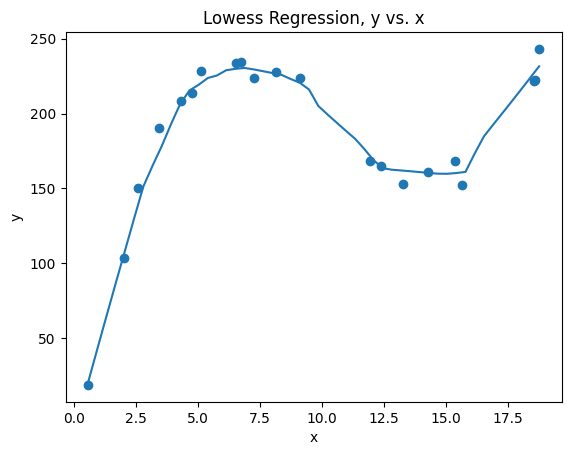

In [159]:
plt.scatter(rawData['x'], rawData['y'])
plt.plot(results['xgrid'], results['ygrid'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Lowess Regression, y vs. x')
plt.show()